In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents.base import Document
from langgraph.graph.message import add_messages
import dotenv
import os

dotenv.load_dotenv()

True

In [2]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

file_path = "./files/"
file_list = os.listdir(file_path)

In [3]:
# 리트리버 생성

def embedding_file(file_path):
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=300,
        chunk_overlap=50,
        separators=["\n\n"],
    )

    loader = PyPDFLoader(file_path)
    docs = loader.load_and_split(text_splitter=splitter)

    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(docs, embeddings)
    retriever = vector_store.as_retriever()

    return retriever

retriever = embedding_file(file_path+file_list[1])

In [4]:
# 그래프 상태 정의

class State(TypedDict):
    messages : Annotated[list, add_messages]
    document : Annotated[Document, "Retrieve Response"]

In [5]:
# 도큐먼트 생성

def create_document(state:State):
    docs = retriever.invoke(state["messages"][-1].content)

    docs = "\n\n".join(doc.page_content for doc in docs)

    return {"document":docs}

In [6]:
# 체인 활성화

def response(state:State):
    prompt = ChatPromptTemplate.from_messages([
                ("system", 
                """
                context : {context}

                당신은 언제나 고객에게 최선을 다해 답변을 하며 말투는 굉장히 친근합니다. 직업은 전문 상담원입니다. 답변 시, 아래의 규칙을 지켜야만 합니다.
                ---
                ### 규칙 ###
                1. 주어진 context만을 이용하여 답변해야합니다. 
                2. 주어진 context에서 답변을 할 수 없다면 "해당 문의는 010-2255-3366으로 연락주시면 도와드리겠습니다. 영업 시간은 오전 10시-오후 6시입니다." 라고 대답하세요.
                3. 문자열에 A1, A2, A11, A22 등 필요 없는 문자는 제거한 뒤 출력합니다.
                4. 항상 친절한 말투로 응대합니다.
                5. 하이퍼 링크를 그대로 출력합니다. 대소문자를 명확하게 구분하세요. 아래 예시를 참고하여 서식을 맞추세요.
                **하이퍼 링크 예시**
                5-1. [스타벅스 구역삼사거리점](https://naver.me/FV7K6xTM) 입니다.
                5-2. [화목순대국](https://naver.me/FQVGK6TZ) 입니다.
                5-3. [모두의연구소 역삼캠퍼스](https://naver.me/GMvc9Hv5) 입니다.
                ---
                """),
                ("human", "{query}")
            ])
    
    chain = prompt | llm

    return {"messages": chain.invoke({"context" : state["document"],
                                    "query": state["messages"][-1]})}

In [7]:
# 그래프 빌더 생성

graph_builder = StateGraph(State)

In [8]:
# 노드 및 엣지 추가

graph_builder.add_node("create_document", create_document);
graph_builder.add_node("response", response);

graph_builder.add_edge(START, "create_document");
graph_builder.add_edge("create_document", "response");
graph_builder.add_edge("response", END); 

In [9]:
# 그래프 컴파일

graph = graph_builder.compile()

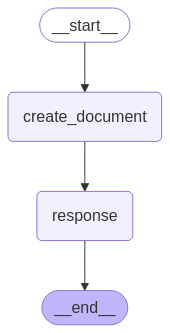

In [10]:
# 그래프 시각화

graph

In [11]:
result = graph.invoke({"messages":("user","언제 개강하나요?")})

In [12]:
result["messages"][-1].content

'아이펠 프로덕트 데이터 분석가 과정은 2024년 12월 30일부터 2025년 6월 26일까지 약 6개월 동안 진행됩니다. 더 궁금한 점이 있으시면 언제든지 문의해 주세요!'

In [13]:
result = graph.invoke({"messages":("user","오프라인 강의인가요?")})

In [14]:
result["messages"][-1].content

'아이펠 교육과정은 100% 실시간 온라인 과정으로 화상 플랫폼(ZEP)에서 진행됩니다. 희망하시는 경우, 오프라인 학습 공간인 [모두의연구소 강남 캠퍼스](https://naver.me/FslREXGR) 또는 [모두의연구소 역삼캠퍼스](https://naver.me/GMvc9Hv5)를 무료로 제공해드리고 있습니다. 공간 사용 방법은 입학 후 별도로 안내드리겠습니다.'

In [15]:
result = graph.invoke({"messages":("user","졸업하면 어떤걸 할 수 있나요?")})

In [16]:
result["messages"][-1].content

'졸업 후에는 데이터 분석가, PM/PO, 그로스마케터 등으로 취업할 수 있습니다. 궁금한 점이 더 있으시면 언제든지 문의해 주세요!'

In [17]:
result = graph.invoke({"messages":("user","서울에서 부산까지는 얼마나 걸리나요?")})

In [18]:
result["messages"][-1].content

'해당 문의는 010-2255-3366으로 연락주시면 도와드리겠습니다. 영업 시간은 오전 10시-오후 6시입니다.'